# Item analysis

Note: `npm run export-items` first.

In [ ]:
import collections
import json
from pathlib import Path
from typing import Any, Iterable

import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 100)
matplotlib.rcParams.update({"figure.figsize": (5, 3), "axes.spines.right": False, "axes.spines.top": False, "legend.frameon": False})

def load_items() -> list[dict[str, Any]]:
    return list(json.loads(Path("items.json").read_text()).values())

grid_size = (9, 9)
offer_count = 3

## Bonuses

In [58]:
df = pd.DataFrame.from_records([item for item in load_items() if item["kind"] == "bonus"])
display(df["freq"].value_counts().to_frame("count"))
display(df[["title", "description", "freq", "limit"]])

,count
freq,
uncommon,11
common,8
rare,5


,title,description,freq,limit
0,−3 nnats/pattern,subtract an additional 3 nnats from every pattern,common,NaN
1,−7 nnats/pattern,subtract an additional 7 nnats from every pattern,uncommon,NaN
2,Symmetry,add 50% pattern multiplier per reflective symmetry,uncommon,1.0
3,Asymmetry,add 100% multiplier to patterns with no reflective symmetries,uncommon,1.0
4,Heavy Hitter,multiply pattern nnats by ×1.1 per cell in the pattern,uncommon,1.0
5,15% Bonus,add a 15% multiplier to each group,common,1.0
6,20% Bonus,add a 20% multiplier to each group,uncommon,1.0
7,Cell Bonus,add 1% multiplier per cell to each group,uncommon,1.0
8,Pattern Bonus,add 5% multiplier per pattern to each group,uncommon,1.0
9,Edge Bonus,add 10% group multiplier per touching grid edge,common,1.0


## Patterns

In [60]:
def pattern_expected_count(pattern_size: tuple[int, int]) -> float:
    chance = (1/2) ** (pattern_size[0] * pattern_size[1])
    placements = (grid_size[0] - pattern_size[0] + 1) * (grid_size[1] - pattern_size[1] + 1)
    return placements * chance

items = load_items()
pattern_shapes = {(x["grid"]["rows"], x["grid"]["cols"]) for x in items if x["kind"] == "pattern"}
df = pd.DataFrame.from_records([
    dict(shape=f"{w}x{h}", count=pattern_expected_count((w, h)))
    for w, h in pattern_shapes
])
df["fair_score"] = df["count"].max() / df["count"]
df["inv_count"] = 1 / df["count"]
print("Score based on expected occurence count:")
display(
    df[["shape", "fair_score", "inv_count"]]
    .sort_values("fair_score")
    .reset_index(drop=True)
    .style.format({"fair_score": "{:.1f}", "inv_count": "{:.1f}"})
)

print("Expected score by pattern:")
display(pd.DataFrame.from_records([
        dict(
            name=item["name"],
            shape=f"{item['grid']['rows']}x{item['grid']['cols']}",
            expected_score=item["points"] * pattern_expected_count((item["grid"]["rows"], item["grid"]["cols"])),
            freq=item["freq"],
        )
        for item in items if item["kind"] == "pattern"
    ])
    # .sort_values("expected_score", ascending=False)
    .reset_index(drop=True)
    .style.format({"expected_score": "{:.1f}"})
)

Score based on expected occurence count:


,shape,fair_score,inv_count
0,2x2,1.0,0.2
1,1x4,1.2,0.3
2,4x1,1.2,0.3
3,2x3,4.6,1.1
4,3x2,4.6,1.1
5,1x6,7.1,1.8
6,6x1,7.1,1.8
7,3x3,41.8,10.4
8,5x2,102.4,25.6
9,9x1,227.6,56.9


Expected score by pattern:


,name,shape,expected_score,freq
0,square_s,2x2,12.0,common
1,square_m,3x3,2.9,common
2,square_l,4x4,0.2,rare
3,square_xl,5x5,0.0,rare
4,line,1x4,10.1,uncommon
5,line_l,1x6,5.6,uncommon
6,line_xxl,1x9,3.5,rare
7,column,4x1,10.1,uncommon
8,column_l,6x1,5.6,uncommon
9,column_xxl,9x1,3.5,rare


## Selection likelihood

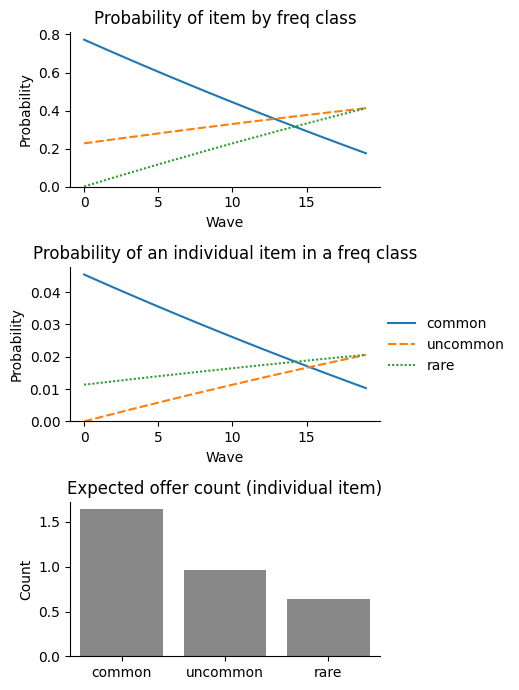

In [ ]:
def linear_schedule(start: dict[str, float], end: dict[str, float], duration: int) -> list[dict[str, float]]:
    schedule = []
    for step in range(duration):
        t = step / (duration - 1)
        current = {key: start[key] + t * (end[key] - start[key]) for key in start}
        schedule.append(current)
    return schedule

def compute_selection_likelihoods(schedule: Iterable[dict[str, float]]) -> Iterable[dict[str, float]]:
    for chance in schedule:
        total_weight = sum(chance[freq] * items_by_freq[freq] for freq in chance)
        yield {freq: (chance[freq] * items_by_freq[freq]) / total_weight for freq in chance}

items = load_items()
items_by_freq = collections.Counter(item["freq"] for item in items)
schedule = linear_schedule(
    dict(common=4, uncommon=1, rare=0),
    dict(common=1, uncommon=2, rare=2),
    duration=20,
)

df = pd.DataFrame.from_dict(list(compute_selection_likelihoods(schedule)))

fig, axs = plt.subplots(3, 1, figsize=(4, 7))
sns.lineplot(data=df, ax=axs[0])
axs[0].set_title("Probability of item by freq class")
sns.lineplot(data=df / pd.Series(items_by_freq), ax=axs[1])
axs[1].set_title("Probability of an individual item in a freq class")
# sns.barplot(data=df / pd.Series(items_by_freq) * offer_count, ax=axs[2])
sns.barplot((df / pd.Series(items_by_freq) * offer_count).sum(), ax=axs[2], color="#888", order=["common", "uncommon", "rare"])
axs[2].set_title("Expected offer count (individual item)")
for ax in axs:
    ax.set_ylim(0, None)
    if ax.legend_:
        ax.legend_.remove()
axs[0].set_ylabel("Probability")
axs[1].set_ylabel("Probability")
axs[0].set_xlabel("Wave")
axs[1].set_xlabel("Wave")
axs[2].set_ylabel("Count")
fig.legend(*axs[0].get_legend_handles_labels(), loc="center left", bbox_to_anchor=(0.95, 0.5))
fig.tight_layout()

## Item coverage

In [59]:
df = pd.read_json(Path("items.json")).T
print("Total:", len(df))
print("Frequency:")
display(df.groupby("freq").size().to_frame("count").style.background_gradient("coolwarm"))
print("Kind:")
display(df.groupby("kind").size().to_frame("count").style.background_gradient("coolwarm"))
print("Kind & Frequency:")
display(
    df.groupby(["kind", "freq"]).size().to_frame("count").reset_index()
    .pivot(columns="freq", index="kind", values="count").fillna(0)
    [["common", "uncommon", "rare"]]
    .style.background_gradient("coolwarm"))

Total: 57
Frequency:


,count
freq,
common,16
rare,16
uncommon,25


Kind:


,count
kind,
action,5
bonus,24
pattern,28


Kind & Frequency:


freq,common,uncommon,rare
kind,,,
action,0.000000,2.000000,3.000000
bonus,8.000000,11.000000,5.000000
pattern,8.000000,12.000000,8.000000
